# Regressão Linear Múltipla com a exclusão de outliers
  - Nova tentativa de ajuste com a exclusão de 230 linhas (filmes com rendimento acima de 20 mi)
  - A renda bruta continua sem distribuiçao normal;
  - O log de renda continua sem relação linear com as demais variáveis

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999 

# Upload do banco

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [105]:
df = pd.read_csv('/content/drive/My Drive/MIA/BilheteriaObrasSemana2.csv', encoding = 'ISO-8859-1', sep = ';', index_col=0)

df.head()

,titulo_original,publico,tempo_exibicao,renda,salas,copias,ano_cinematografico,razao_social_distribuidora,internacional_nacional,genero
0,OS DEZ MANDAMENTOS,11305479,222 days,116833026.879999995,7319,263,2016,SM DISTRIBUIDORA DE FILMES LTDA,1,Ficção
1,TROPA DE ELITE 2,11146723,168 days,103461153.739999995,6240,5674,2011,ZAZEN PRODUÇÕES AUDIOVISUAIS LTDA.,1,Ficção
2,THE AVENGERS,10911371,132 days,129595590.000000000,6693,4043,2012,THE WALT DISNEY COMPANY (BRASIL) LTDA.,0,Ficção
3,THE AVENGERS: AGE OF ULTRON,10129071,132 days,146184931.000000000,7881,7881,2015,THE WALT DISNEY COMPANY (BRASIL) LTDA.,0,Ficção
4,FURIOUS SEVEN,9857968,138 days,142466037.020000011,5961,5961,2016,COLUMBIA TRISTAR FILMES DO BRASIL LTDA,0,Ficção


In [ ]:
df.info()

# Feature engineering

* Tempo de exibição em formato numérico (dias)
* Labels para internacional_nacional
* Agrupamento das distribuidoras em 3 categorias (alta, média e baixa renda),  segundo o rendimento arrecadado ao longo do período
* Descrição geral dos dados

In [106]:
df['tempo_exibicao2'] = df['tempo_exibicao'].str.split(' ').str[0]
df.head(2)

,titulo_original,publico,tempo_exibicao,renda,salas,copias,ano_cinematografico,razao_social_distribuidora,internacional_nacional,genero,tempo_exibicao2
0,OS DEZ MANDAMENTOS,11305479,222 days,116833026.879999995,7319,263,2016,SM DISTRIBUIDORA DE FILMES LTDA,1,Ficção,222
1,TROPA DE ELITE 2,11146723,168 days,103461153.739999995,6240,5674,2011,ZAZEN PRODUÇÕES AUDIOVISUAIS LTDA.,1,Ficção,168


In [107]:
df['tempo_exibicao2'] = df['tempo_exibicao2'].astype(int)

In [108]:
df.drop(columns=['tempo_exibicao'], inplace=True)
df.head(2)

,titulo_original,publico,renda,salas,copias,ano_cinematografico,razao_social_distribuidora,internacional_nacional,genero,tempo_exibicao2
0,OS DEZ MANDAMENTOS,11305479,116833026.879999995,7319,263,2016,SM DISTRIBUIDORA DE FILMES LTDA,1,Ficção,222
1,TROPA DE ELITE 2,11146723,103461153.739999995,6240,5674,2011,ZAZEN PRODUÇÕES AUDIOVISUAIS LTDA.,1,Ficção,168


In [109]:
df["internacional_nacional"] = df["internacional_nacional"].replace({
      0 : "Internacional"
    , 1 : "Nacional"
})
df.head(3)

,titulo_original,publico,renda,salas,copias,ano_cinematografico,razao_social_distribuidora,internacional_nacional,genero,tempo_exibicao2
0,OS DEZ MANDAMENTOS,11305479,116833026.879999995,7319,263,2016,SM DISTRIBUIDORA DE FILMES LTDA,Nacional,Ficção,222
1,TROPA DE ELITE 2,11146723,103461153.739999995,6240,5674,2011,ZAZEN PRODUÇÕES AUDIOVISUAIS LTDA.,Nacional,Ficção,168
2,THE AVENGERS,10911371,129595590.000000000,6693,4043,2012,THE WALT DISNEY COMPANY (BRASIL) LTDA.,Internacional,Ficção,132


In [ ]:
dist = df['razao_social_distribuidora'].value_counts(sort=True, ascending=False, normalize = False)
dist.head(30)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.9f' % x)
df.groupby('razao_social_distribuidora')['renda'].mean().sort_values(ascending=False)

In [110]:
dist_dict = {
'UNIVERSAL PICTURES INTERNATIONAL BRAZIL LTDA.': 'major', #major: acima de 10 Mi#
'THE WALT DISNEY COMPANY (BRASIL) LTDA.': 'major',
'ZAZEN PRODUÇÕES AUDIOVISUAIS LTDA.': 'major',
'FOX FILM DO BRASIL LTDA': 'major',
'WARNER BROS. (SOUTH) INC.': 'major',
'PARAMOUNT PICTURES BRASIL DISTRIBUIDORA DE FILMES LTDA': 'major',
'COLUMBIA TRISTAR FILMES DO BRASIL LTDA': 'media', #media: de 1 até 10 Mi#
'FREESPIRIT DISTRIBUIDORA DE FILMES LTDA.': 'media',
'SM DISTRIBUIDORA DE FILMES LTDA': 'media',
'CANZION DO BRASIL LTDA': 'media',
'H2O DISTRIBUIDORA DE FILMES LTDA': 'media',
'WMIX DISTRIBUIDORA LTDA.': 'media',
'DIAMOND FILMS DO BRASIL PRODUÇÃO E DISTRIBUIÇÃO AUDIOVISUAL LTDA.': 'media',
'PLAYARTE PICTURES ENTRETENIMENTOS LTDA.': 'media',
'GRAÇA FILMES PRODUTORA E DISTRIBUIDORA LTDA': 'media',
'ELIMAR PRODUÇÕES ARTÍSTICAS LTDA': 'media',
'CUATRO DAMAS FILMES LTDA.': 'media',
'CANNES PRODUÇÕES S/A': 'media',
'CHATO LTDA': 'media'
}
# O valor de corte faz referência aos rendimentos médios das distribuidoras, conforme tabela acima. Major: rendimento médio para todo o período acima de 10 milhões de reais;
# Média: rendimento médio de 1 até 10 milhões de reais;
# Menores: rendimento médio abaixo de 1 milhão de reais.

df['distribuidoras2'] = df['razao_social_distribuidora'].map(dist_dict).fillna('menores')
df.head(3)

,titulo_original,publico,renda,salas,copias,ano_cinematografico,razao_social_distribuidora,internacional_nacional,genero,tempo_exibicao2,distribuidoras2
0,OS DEZ MANDAMENTOS,11305479,116833026.879999995,7319,263,2016,SM DISTRIBUIDORA DE FILMES LTDA,Nacional,Ficção,222,media
1,TROPA DE ELITE 2,11146723,103461153.739999995,6240,5674,2011,ZAZEN PRODUÇÕES AUDIOVISUAIS LTDA.,Nacional,Ficção,168,major
2,THE AVENGERS,10911371,129595590.000000000,6693,4043,2012,THE WALT DISNEY COMPANY (BRASIL) LTDA.,Internacional,Ficção,132,major


#### Descrição

In [30]:
pd.set_option('display.float_format', lambda x: '%.9f' % x)
df.describe(percentiles = [.01, .05, .25, .5, .75, .95, .99])

,publico,renda,salas,copias,ano_cinematografico,tempo_exibicao2
count,3870.000000000,3870.000000000,3870.000000000,3870.000000000,3870.000000000,3870.000000000
mean,356853.985529716,4308007.604987080,508.650904393,448.698191214,2013.656072351,79.312144703
std,1062035.766056742,13368715.106647801,1080.468252282,983.837254040,2.678867854,59.764219527
min,0.000000000,0.000000000,1.000000000,1.000000000,2009.000000000,6.000000000
1%,24.000000000,140.970000000,1.000000000,1.000000000,2009.000000000,6.000000000
5%,167.350000000,1189.346000000,3.000000000,3.000000000,2009.000000000,12.000000000
25%,2474.500000000,25963.087500000,25.000000000,23.000000000,2011.000000000,36.000000000
50%,15330.500000000,180637.750000000,84.000000000,73.000000000,2014.000000000,72.000000000
75%,143373.000000000,1703856.472500000,405.000000000,354.750000000,2016.000000000,108.000000000
95%,2106863.349999999,24655262.260499965,2754.050000000,2307.550000000,2017.000000000,186.000000000


In [ ]:
df.loc[df['renda'] == 0.0000000000]

,titulo_original,publico,renda,salas,copias,ano_cinematografico,razao_social_distribuidora,internacional_nacional,genero,tempo_exibicao2,distribuidoras2
3869,LA CHIAVI DI CASA,0,0.000000000,2,2,2009,ESTAÇÃO CINEMA E CULTURA LTDA,Internacional,Ficção,12,menores


In [ ]:
df.loc[df['renda'] == 146184931.000000000]

,titulo_original,publico,renda,salas,copias,ano_cinematografico,razao_social_distribuidora,internacional_nacional,genero,tempo_exibicao2,distribuidoras2
3,THE AVENGERS: AGE OF ULTRON,10129071,146184931.000000000,7881,7881,2015,THE WALT DISNEY COMPANY (BRASIL) LTDA.,Internacional,Ficção,132,major


In [96]:
alto = len(df[(df['renda'] > 20000000)])
medio = len(df[(df['renda'] <= 20000000) & (df['renda'] >= 1000000)])
baixo = len(df[(df['renda'] < 1000000)])
print(alto)
print(medio)
print(baixo)

230
944
2696


In [111]:
df.drop(df[(df['renda'] > 20000000.000000000) & (df['renda'] <= 146184931.000000000)].index, inplace=True)
df.head(2)

,titulo_original,publico,renda,salas,copias,ano_cinematografico,razao_social_distribuidora,internacional_nacional,genero,tempo_exibicao2,distribuidoras2
184,OS NORMAIS 2,2202640,18978259.879999999,3129,3088,2009,WMIX DISTRIBUIDORA LTDA.,Nacional,Ficção,102,media
189,TRANSFORMERS: REVENGE OF THE FALLEN,2149681,17483513.000000000,2904,2786,2009,PARAMOUNT PICTURES BRASIL DISTRIBUIDORA DE FIL...,Internacional,Ficção,108,major


# Análise exploratória para modelagem

O objetivo é checar o comportamento do nosso target com as demais features; alguns gráficos podem ajudar a perceber se há linearidade entre as features com o target.

**Sugestões adicionais:**

* Montar gráficos com a linha de regressão pareada entre feature e target


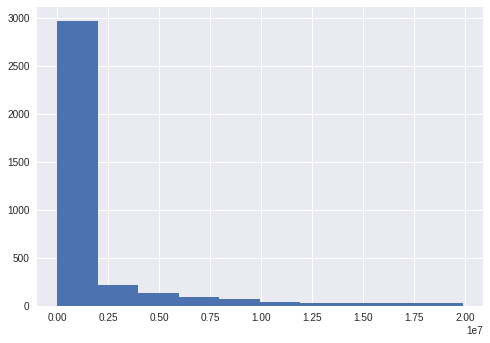

In [113]:
df['renda'].hist()

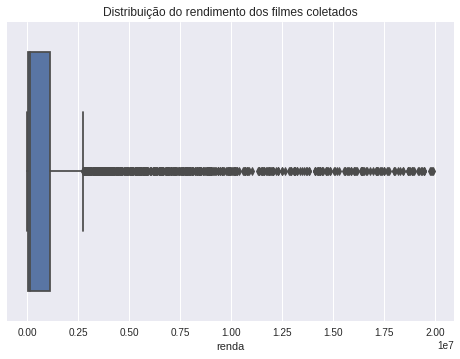

In [114]:
sns.boxplot(df.renda).set_title("Distribuição do rendimento dos filmes coletados");

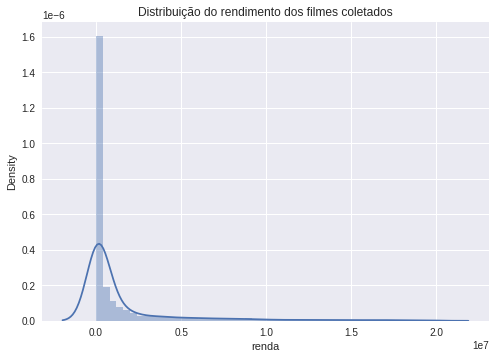

In [115]:
sns.distplot(df.renda).set_title("Distribuição do rendimento dos filmes coletados");

Teste de normalidade do target (pressuposto do modelo de regressão linear)

In [116]:
from scipy.stats import shapiro
shapiro(df['renda'])
# Since the p-value is less than .05, we reject the null hypothesis. 
# We have sufficient evidence to say that the sample data does not come from a normal distribution.

ShapiroResult(statistic=0.5186487436294556, pvalue=0.0)



---



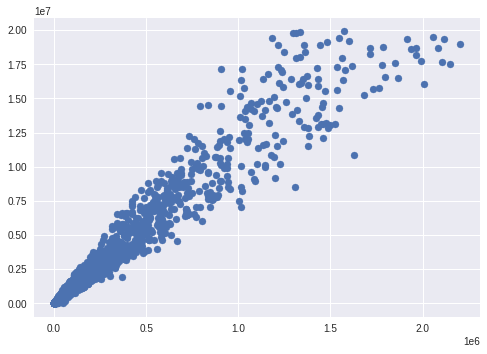

In [117]:
plt.scatter(df['publico'], df['renda'])
plt.show()

# Fazer múltiplos gráficos já com a linha de regressão

A relação parece ser linear.

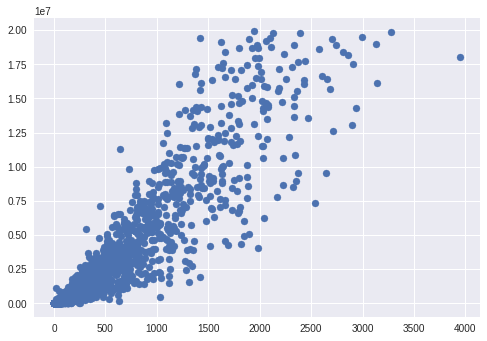

In [118]:
plt.scatter(df['salas'], df['renda'])
plt.show()

A relação parece ser curvilínea.

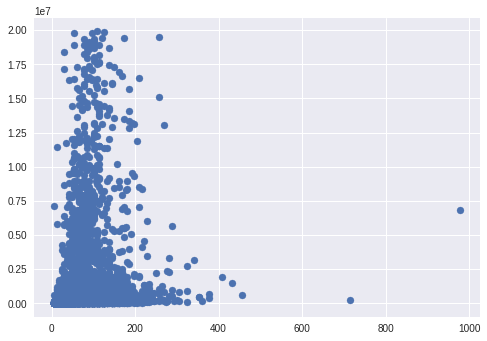

In [119]:
plt.scatter(df['tempo_exibicao2'], df['renda'])
plt.show()

A relação não parece ser linear.

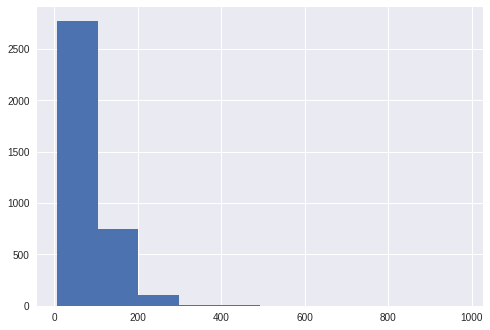

In [120]:
df['tempo_exibicao2'].hist()

O tempo de exibição parece ter o mesmo comportamento da renda, inclinado para a esquerda (valores mais baixos)

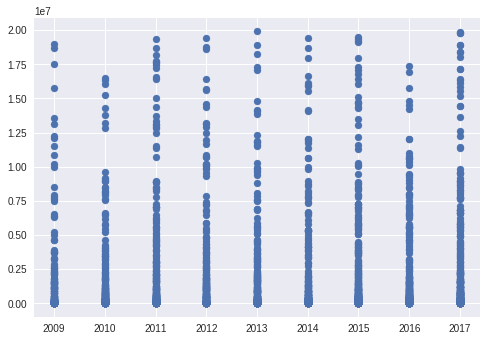

In [121]:
plt.scatter(df['ano_cinematografico'], df['renda'])
plt.show()

De certa forma parece uma relação linear, de crescimento de renda com o passar dos anos

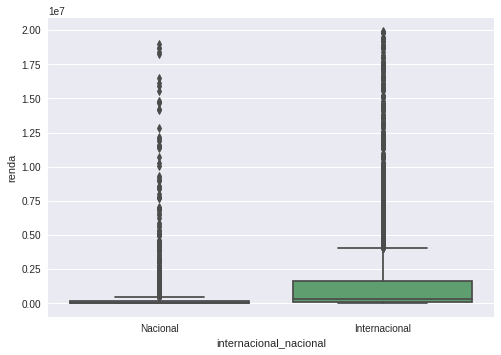

In [122]:
sns.boxplot(x = df['internacional_nacional'], y = df['renda']) # melhorar tirando alguns outliers

Os filmes internacionais parecem ter maiores rendimentos e um número maior de outliers

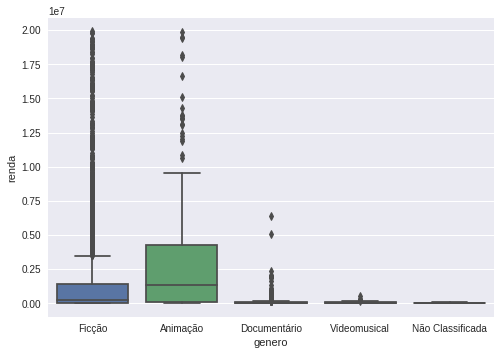

In [123]:
ax = sns.boxplot(x = df['genero'], y = df['renda'])

Os filmes de animação parecem ser aqueles com menor variabilidade em termos de rendimento, em comparação com os filmes de ficção e documentário. Com o gráfico abaixo, parece ter os maiores rendimentos médios

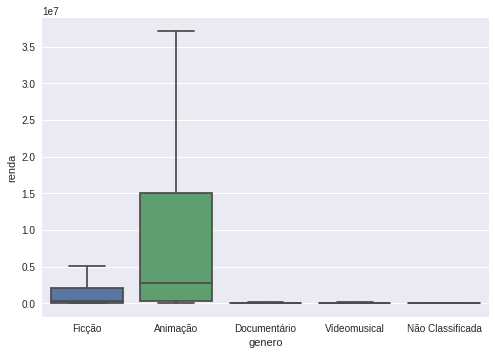

In [ ]:
sns.boxplot(x = df['genero'], y = df['renda'], showfliers = False) 

Visualização ao remover os outliers da análise.

[Rotacionar os labels no eixo x qualquer coisa](https://drawingfromdata.com/seaborn/matplotlib/visualization/rotate-axis-labels-matplotlib-seaborn.html).

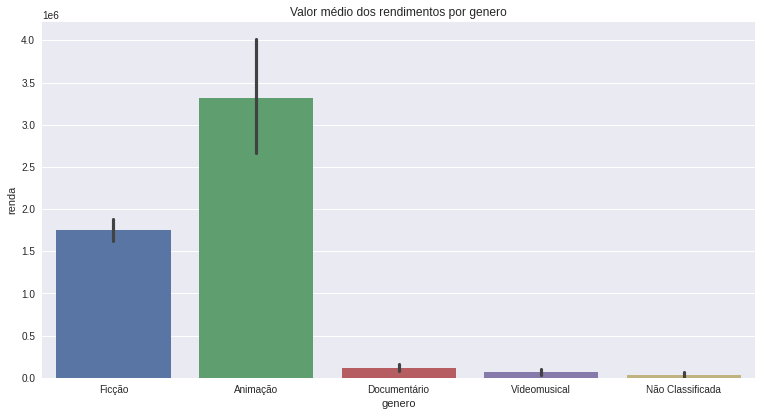

In [124]:
ax = sns.catplot(x="genero", y="renda", data=df, kind="bar").set(title="Valor médio dos rendimentos por genero");
ax.figure.set_size_inches(12,6)
#ax.set_xticklabels(rotation=45)

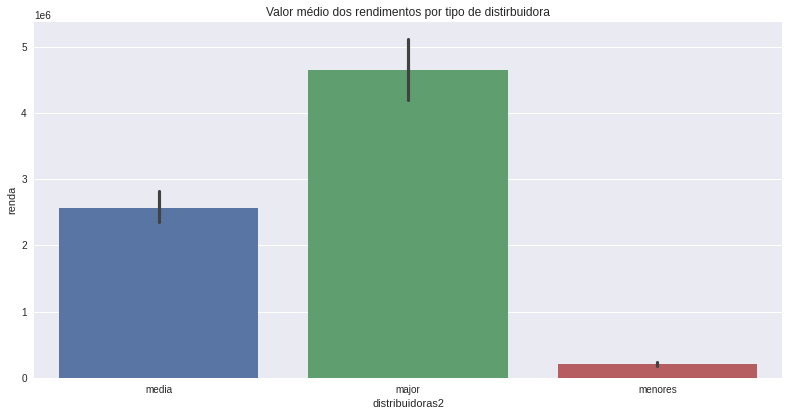

In [125]:
ax = sns.catplot(x="distribuidoras2", y="renda", data=df, kind="bar").set(title="Valor médio dos rendimentos por tipo de distirbuidora");
ax.figure.set_size_inches(12,6)
#ax.set_xticklabels(rotation=45)

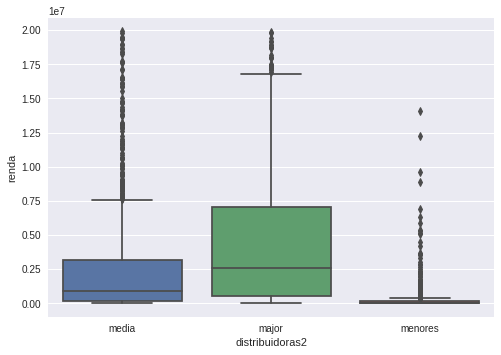

In [126]:
sns.boxplot(x = df['distribuidoras2'], y = df['renda'])

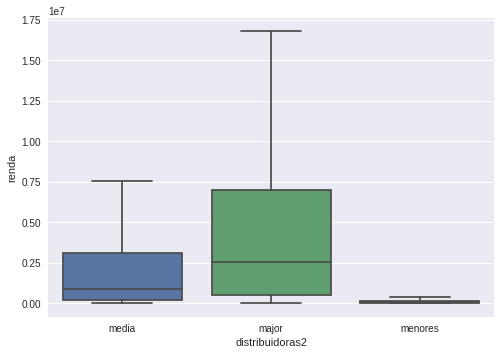

In [127]:
# removento outliers
sns.boxplot(x = df['distribuidoras2'], y = df['renda'], showfliers = False)

#### Matriz de correlação com as variáveis quantitativas (renda bruta)

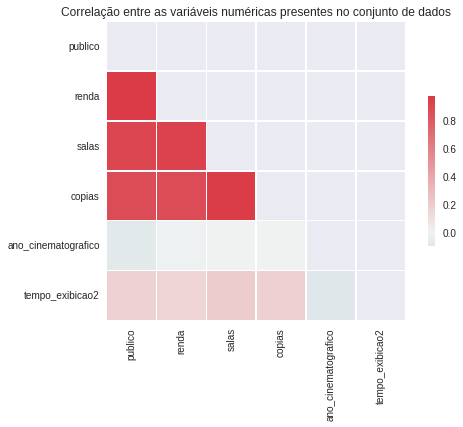

In [128]:
# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Correlação entre as variáveis numéricas presentes no conjunto de dados");



---


# Featuring engineering: preparo do banco para o modelo de regressão linear múltipla


---


* Tratamento das variáveis categóricas (get_dummies)
* Exclusão de colunas identificatórias e de colunas que possuem alta correlação entre si (correlação alta apenas com o target não é problema); exclusão de colunas dummy
* Matriz de correlação com as dummies

In [182]:
df2 = df.copy(deep = True)

In [183]:
df2 = pd.get_dummies(df2, columns=['internacional_nacional', 'genero', 'distribuidoras2'])

In [184]:
df2.columns.values


array(['titulo_original', 'publico', 'renda', 'salas', 'copias',
       'ano_cinematografico', 'razao_social_distribuidora',
       'tempo_exibicao2', 'internacional_nacional_Internacional',
       'internacional_nacional_Nacional', 'genero_Animação',
       'genero_Documentário', 'genero_Ficção', 'genero_Não Classificada',
       'genero_Vídeomusical', 'distribuidoras2_major',
       'distribuidoras2_media', 'distribuidoras2_menores'], dtype=object)

In [185]:
df2.drop(columns=['copias', 'salas', 'razao_social_distribuidora', 'titulo_original', 'internacional_nacional_Internacional'], inplace=True)
df2.head(2)

,publico,renda,ano_cinematografico,tempo_exibicao2,internacional_nacional_Nacional,genero_Animação,genero_Documentário,genero_Ficção,genero_Não Classificada,genero_Vídeomusical,distribuidoras2_major,distribuidoras2_media,distribuidoras2_menores
184,2202640,18978259.879999999,2009,102,1,0,0,1,0,0,0,1,0
189,2149681,17483513.000000000,2009,108,0,0,0,1,0,0,1,0,0


#### Matriz de correlação com as dummies categóricas (renda bruta)

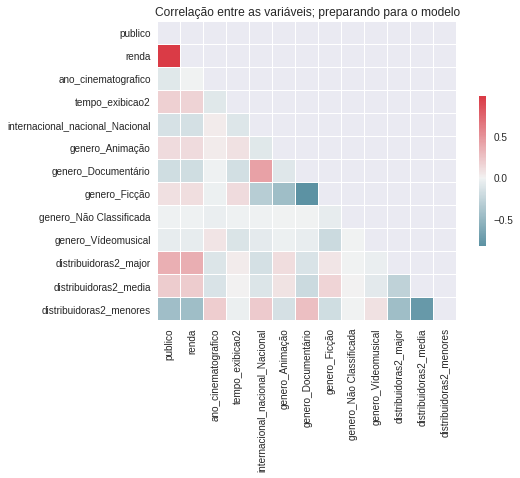

In [133]:
# Um heatmap, agora com as dummies categoricas
# Generate a mask for the upper triangle
mask = np.zeros_like(df2.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df2.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Correlação entre as variáveis; preparando para o modelo");


# Modelo 1 (sem nenhuma transformação no target) (renda bruta)

## Regressão linear múltipla

Ver depois como checar pressupostos [aqui](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/).

In [134]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#### Separação do conjunto de treino e teste

In [135]:
Y = df2['renda']
del df2['renda']
X = df2

In [136]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

In [ ]:
print(X_train.shape)
X_train.head(1)

(2902, 12)


,publico,ano_cinematografico,tempo_exibicao2,internacional_nacional_Nacional,genero_Animação,genero_Documentário,genero_Ficção,genero_Não Classificada,genero_Vídeomusical,distribuidoras2_major,distribuidoras2_media,distribuidoras2_menores
1075,107372,2012,48,0,0,0,1,0,0,0,1,0


In [ ]:
print(Y_train.shape)
Y_train.head(1)

(2902,)


1075   1332599.560000000
Name: renda, dtype: float64

In [ ]:
print(X_test.shape)
X_test.head(1)

(968, 12)


,publico,ano_cinematografico,tempo_exibicao2,internacional_nacional_Nacional,genero_Animação,genero_Documentário,genero_Ficção,genero_Não Classificada,genero_Vídeomusical,distribuidoras2_major,distribuidoras2_media,distribuidoras2_menores
2176,10153,2010,114,1,0,0,1,0,0,0,1,0


In [ ]:
print(Y_test.shape)
Y_test.head(1)

(968,)


2176   83428.110000000
Name: renda, dtype: float64

In [137]:
columns = ['publico', 'ano_cinematografico', 'tempo_exibicao2', 'internacional_nacional_Nacional', 'genero_Animação', 
           'genero_Documentário', 'genero_Ficção', 'genero_Não Classificada', 'genero_Vídeomusical', 
           'distribuidoras2_major', 'distribuidoras2_media', 'distribuidoras2_menores']

# Features no modelo: publico, ano, tempo_exibicao2, internacional_nacional, genero, distribuidoras2

#### Definição do modelo 1

In [138]:
lm = LinearRegression()

In [139]:
lm.fit(X_train[columns], Y_train)

LinearRegression()

In [140]:
Y_pred = lm.predict(X_test[columns])

In [141]:
beta=lm.coef_
intercept=lm.intercept_

In [ ]:
beta.tolist()

[12.576899581547275,
 216463.64118284415,
 -2560.540027055453,
 -298956.82147540024,
 -687256.387685831,
 262675.9835341974,
 27869.023850259164,
 890897.2042479377,
 -494185.82394656434,
 129875.68755706493,
 -115922.49497746608,
 -13953.192579598051]

In [142]:
intercept

-190103433.30396008

Text(0.5, 1.0, 'Distribuição do target vs valor predito pelo modelo')

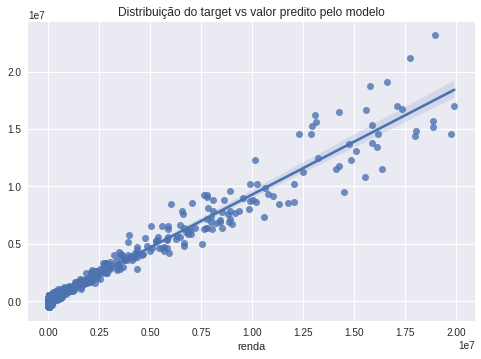

In [143]:
sns.regplot(x=Y_test, y=Y_pred).set_title("Distribuição do target vs valor predito pelo modelo")

#### Métricas de avaliação

In [144]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [145]:
mse = mean_squared_error(Y_test, Y_pred)
mse

536377684693.6667

In [146]:
mae = mean_absolute_error(Y_test, Y_pred)
mae

384139.99028824095

In [147]:
r2_score(Y_test, Y_pred)

0.958123336454846

In [148]:
weights = pd.DataFrame(list(zip(columns, lm.coef_.tolist())),columns=['names', 'coefs'])
weights

,names,coefs
0,publico,10.670339560
1,ano_cinematografico,94528.821638342
2,tempo_exibicao2,-360.768690844
3,internacional_nacional_Nacional,-122109.233045870
4,genero_Animação,-84293.906869020
5,genero_Documentário,53142.421025598
6,genero_Ficção,-14024.522024920
7,genero_Não Classificada,247347.927856069
8,genero_Vídeomusical,-202171.919987727
9,distribuidoras2_major,159106.080080805


In [149]:
import statsmodels.api as sm
from scipy import stats

In [150]:
X2 = sm.add_constant(X_test[columns])
est = sm.OLS(Y_test, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     2420.
Date:                Mon, 26 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:36:51   Log-Likelihood:                -13555.
No. Observations:                 910   AIC:                         2.713e+04
Df Residuals:                     900   BIC:                         2.718e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

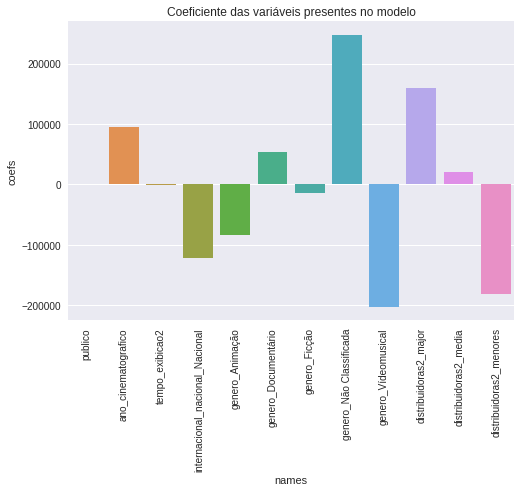

In [151]:
sns.barplot(weights.names, weights.coefs).set_title("Coeficiente das variáveis presentes no modelo");
plt.xticks(rotation=90);

In [152]:
animac = pd.crosstab(index=df2["genero_Animação"], columns="count")
ficcao = pd.crosstab(index=df2["genero_Ficção"], columns="count")
document = pd.crosstab(index=df2["genero_Documentário"], columns="count")

print(animac)
print(ficcao)
print(document)

col_0            count
genero_Animação       
0                 3462
1                  178
col_0          count
genero_Ficção       
0                755
1               2885
col_0                count
genero_Documentário       
0                     3103
1                      537


In [ ]:
animac2 = pd.crosstab(index=df["genero"], columns="count")
print(animac2)

col_0             count
genero                 
Animação            229
Documentário        538
Ficção             3063
Não Classificada      2
Vídeomusical         38


# Análise de resíduos do Modelo 1


Text(0.5, 1.0, 'Distribuição dos resíduos')

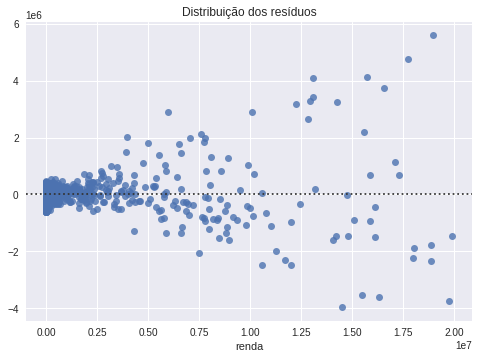

In [153]:
sns.residplot(x=Y_test, y=Y_pred).set_title("Distribuição dos resíduos")

A distribuição dos resíduos é adequada até renda = 0.3 (Relação). Para valores superiores, nota-se a influência de valores outliers na distribuição dos resíduos, dispersando-os do eixo 0. Esses outliers podem estar também relacionados aos valores de MSE e MAE, observados acima.



---



# Modelo 2 (com a remoção do gênero "Não classificada" e gênero "Vídeomusical" e "tempo_exibicao2')

## Regressão linear múltipla

* A alta presença de zeros pode prejudicar o ajuste do modelo

---


In [154]:
df3 = df.copy(deep = True)
df3.head(2)

,titulo_original,publico,renda,salas,copias,ano_cinematografico,razao_social_distribuidora,internacional_nacional,genero,tempo_exibicao2,distribuidoras2
184,OS NORMAIS 2,2202640,18978259.879999999,3129,3088,2009,WMIX DISTRIBUIDORA LTDA.,Nacional,Ficção,102,media
189,TRANSFORMERS: REVENGE OF THE FALLEN,2149681,17483513.000000000,2904,2786,2009,PARAMOUNT PICTURES BRASIL DISTRIBUIDORA DE FIL...,Internacional,Ficção,108,major


In [155]:
df3 = pd.get_dummies(df3, columns=['internacional_nacional', 'genero', 'distribuidoras2'])

In [ ]:
df3.columns.values

array(['titulo_original', 'publico', 'renda', 'salas', 'copias',
       'ano_cinematografico', 'razao_social_distribuidora',
       'tempo_exibicao2', 'internacional_nacional_Internacional',
       'internacional_nacional_Nacional', 'genero_Animação',
       'genero_Documentário', 'genero_Ficção', 'genero_Não Classificada',
       'genero_Vídeomusical', 'distribuidoras2_major',
       'distribuidoras2_media', 'distribuidoras2_menores'], dtype=object)

In [156]:
df3.drop(columns=['titulo_original', 'salas', 'copias', 'razao_social_distribuidora', 'internacional_nacional_Internacional', 'genero_Não Classificada', 'genero_Vídeomusical', 'tempo_exibicao2'], inplace=True)
df3.head(2)

,publico,renda,ano_cinematografico,internacional_nacional_Nacional,genero_Animação,genero_Documentário,genero_Ficção,distribuidoras2_major,distribuidoras2_media,distribuidoras2_menores
184,2202640,18978259.879999999,2009,1,0,0,1,0,1,0
189,2149681,17483513.000000000,2009,0,0,0,1,1,0,0


#### Separação do conjunto de treino e teste do segundo modelo

* Sem os gêneros não classificado e videomusical



In [157]:
Y2 = df3['renda']
del df3['renda']
X2 = df3

In [158]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = 0.25, random_state = 42)

In [ ]:
print(X2_train.shape)
X2_train.head(1)

(2902, 10)


,publico,ano_cinematografico,tempo_exibicao2,internacional_nacional_Nacional,genero_Animação,genero_Documentário,genero_Ficção,distribuidoras2_major,distribuidoras2_media,distribuidoras2_menores
1075,107372,2012,48,0,0,0,1,0,1,0


In [ ]:
print(Y2_train.shape)
Y2_train.head(1)

(2902,)


1075   1332599.560000000
Name: renda, dtype: float64

In [ ]:
print(X2_test.shape)
X2_test.head(1)

(968, 10)


,publico,ano_cinematografico,tempo_exibicao2,internacional_nacional_Nacional,genero_Animação,genero_Documentário,genero_Ficção,distribuidoras2_major,distribuidoras2_media,distribuidoras2_menores
2176,10153,2010,114,1,0,0,1,0,1,0


In [ ]:
print(Y2_test.shape)
Y2_test.head(1)

(968,)


2176   83428.110000000
Name: renda, dtype: float64

In [159]:
columns2 = ['publico', 'ano_cinematografico', 'internacional_nacional_Nacional', 'genero_Animação', 
           'genero_Documentário', 'genero_Ficção', 'distribuidoras2_major', 'distribuidoras2_media', 'distribuidoras2_menores']

# Features no modelo: publico, ano, tempo_exibicao2, internacional_nacional, genero, distribuidoras2

#### Definição do Modelo 2

In [160]:
lm2 = LinearRegression()

In [161]:
lm2.fit(X2_train[columns2], Y2_train)

LinearRegression()

In [162]:
Y2_pred = lm2.predict(X2_test[columns2])

In [163]:
beta2 = lm2.coef_
intercept2 = lm2.intercept_

In [ ]:
beta2.tolist()

[12.57705901621469,
 216023.4123707518,
 -2561.9875927462126,
 -299045.39496301976,
 -239172.84060428757,
 710065.3253459386,
 475537.67561244254,
 129537.52668014672,
 -116018.51916442292,
 -13519.007515724596]

In [164]:
intercept2

-191599987.44192114

Text(0.5, 1.0, 'Distribuição do target vs valor predito pelo modelo')

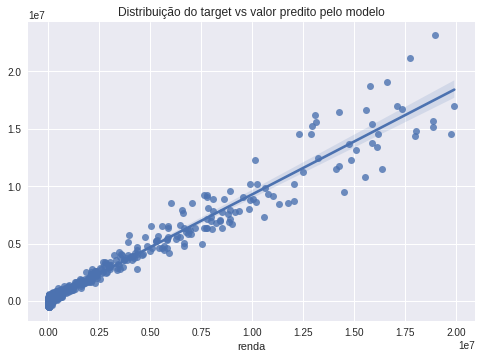

In [165]:
sns.regplot(x=Y2_test, y=Y2_pred).set_title("Distribuição do target vs valor predito pelo modelo")

#### Métricas do Modelo 2

In [166]:
mse2 = mean_squared_error(Y2_test, Y2_pred)
mse2

536764610652.31354

In [167]:
mae2 = mean_absolute_error(Y2_test, Y2_pred)
mae2

383946.9716209916

In [168]:
r2_score(Y2_test, Y2_pred)

0.9580931279494411

In [169]:
weights2 = pd.DataFrame(list(zip(columns2, lm2.coef_.tolist())),columns=['names', 'coefs'])
weights2

,names,coefs
0,publico,10.656691148
1,ano_cinematografico,95184.385882417
2,internacional_nacional_Nacional,-119534.810566288
3,genero_Animação,61236.451020003
4,genero_Documentário,212086.703076215
5,genero_Ficção,136224.258308033
6,distribuidoras2_major,161471.003111487
7,distribuidoras2_media,23120.968019436
8,distribuidoras2_menores,-184591.971130923


In [170]:
X2sq = sm.add_constant(X2_test[columns2])
est2 = sm.OLS(Y2_test, X2sq)
est2sq = est2.fit()
print(est2sq.summary())

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     2724.
Date:                Mon, 26 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:40:00   Log-Likelihood:                -13556.
No. Observations:                 910   AIC:                         2.713e+04
Df Residuals:                     901   BIC:                         2.717e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

Em teoria, como as categorias de gênero acabaram perdendo significância estatística, não faz muito sentido interpretar os coeficientes delas... Nem do tempo de exibição.

* Podemos contruir um novo modelo sem as features que não têm significância estatística;
* Em seguida podemos comparar com a ANOVA ou alguma outra métrica de comparação

[Model evaluation sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html)

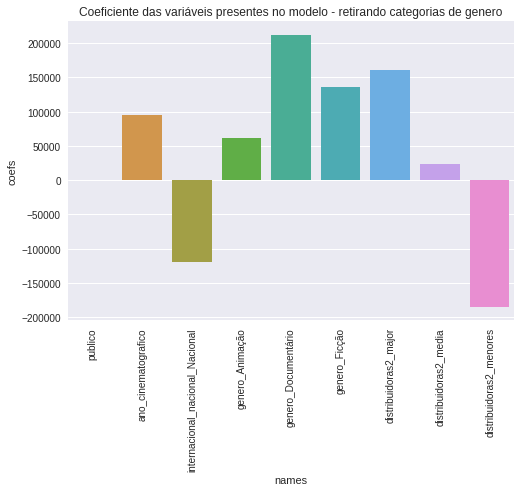

In [171]:
sns.barplot(weights2.names, weights2.coefs).set_title("Coeficiente das variáveis presentes no modelo - retirando categorias de genero");
plt.xticks(rotation=90);

# Análise de resíduos do Modelo 2



Em seguida, é interessantes criar um novo banco, para testar o modelo transformando a variável renda de duas formas (e não deixar esse código mais poluído):

* Normalização
* Transformação logarítmica

Text(0.5, 1.0, 'Distribuição dos resíduos')

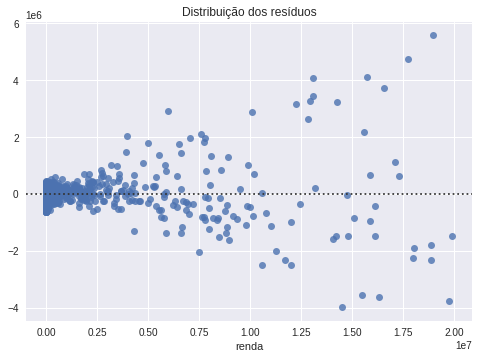

In [172]:
sns.residplot(x=Y2_test, y=Y2_pred).set_title("Distribuição dos resíduos")

A distribuição dos resíduos é adequada até renda = 0.3 (Relação). Para valores superiores, nota-se a influência de valores outliers na distribuição dos resíduos, dispersando-os do eixo 0.

### Distribuição dos resíduos - Modelo 1 e Modelo 2

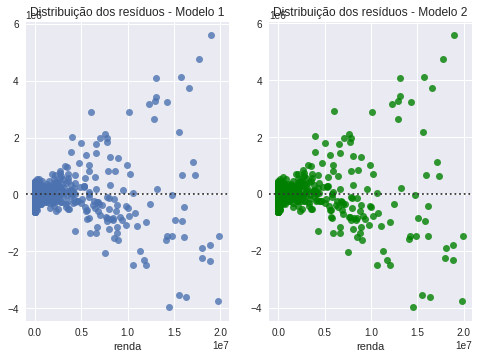

In [173]:
fig,ax =plt.subplots(1,2)
sns.residplot(x=Y_test, y=Y_pred,ax=ax[0]).set_title("Distribuição dos resíduos - Modelo 1")
sns.residplot(x=Y2_test, y=Y2_pred,ax=ax[1], color = 'green').set_title("Distribuição dos resíduos - Modelo 2")
fig.show()

Não houve diferença na distribuição dos resíduos entre os Modelos 1 e 2.



---
# Modelo 3 (com a transformação logarítmica da renda)

* Por que: 

"Logarithmic transformation is a convenient means of transforming a highly skewed variable into a more normalized dataset. When modeling variables with non-linear relationships, the chances of producing errors may also be skewed negatively. In theory, we want to produce the smallest error possible when making a prediction, while also taking into account that we should not be overfitting the model. Overfitting occurs when there are too many dependent variables in play that it does not have enough generalization of the dataset to make a valid prediction. Using the logarithm of one or more variables improves the fit of the model by transforming the distribution of the features to a more normally-shaped bell curve."
"Keynote: 0.1 unit change in log(x) is equivalent to 10% increase in X"

[Fonte](https://dev.to/rokaandy/logarithmic-transformation-in-linear-regression-models-why-when-3a7c).


Transformações com exemplos [aqui](https://www.kaggle.com/code/dssant85/linear-regression-with-logarithmic-transformation/notebook).
Guia de outras transformações possíveis [aqui.](https://towardsdatascience.com/feature-transformation-for-multiple-linear-regression-in-python-8648ddf070b8)

* Acredito que a transformação logarítmica seja mais apropriada devido à inclinação à esquerda da curva e diversos valores discrepantes (poucos filmes de altíssima renda). Contudo, isso pode ser interpretado como uma caraterística do target, e não como outliers a serem removidos. Nosso interesse é justamente conhecer o comportamento de filmes de alto rendimento.

---





#### Feature engineering

* Cópia do df2 (para não termos que fazer as transformações mais uma vez)
* Transformação logarítmica da renda, com breve comparação entre a distribuição log e bruta do target
* Criação de um novo banco com as novas informações; podemos começar a análise daqui sem precisar rodar o restante do código
* Exclusão da coluna 'renda'

In [186]:
df4 = df2.copy(deep = True)

In [187]:
df4.head(2)

,publico,renda,ano_cinematografico,tempo_exibicao2,internacional_nacional_Nacional,genero_Animação,genero_Documentário,genero_Ficção,genero_Não Classificada,genero_Vídeomusical,distribuidoras2_major,distribuidoras2_media,distribuidoras2_menores
184,2202640,18978259.879999999,2009,102,1,0,0,1,0,0,0,1,0
189,2149681,17483513.000000000,2009,108,0,0,0,1,0,0,1,0,0


In [188]:
df4['log_renda'] = np.log(df4['renda'])

In [189]:
df4 = df4.drop(df4.index[-1]) # tive que excluir a última linha, pois log de 0 é -inf. Apenas um filme teve rendimento zero.

# ou df = pd.DataFrame(technologies)
#df1 = df.loc[df["Discount"] >=1500 ]
#print(df1)

In [190]:
df4.to_csv('/content/drive/My Drive/MIA/Logrenda2_BilheteriaObrasSemana.csv', encoding = 'ISO-8859-1', sep = ';')

#### Começar daqui com o novo banco

In [208]:
df4 = pd.read_csv('/content/drive/My Drive/MIA/Logrenda2_BilheteriaObrasSemana.csv', encoding = 'ISO-8859-1', sep = ';', index_col=0)
df4.head(3)

,publico,renda,ano_cinematografico,tempo_exibicao2,internacional_nacional_Nacional,genero_Animação,genero_Documentário,genero_Ficção,genero_Não Classificada,genero_Vídeomusical,distribuidoras2_major,distribuidoras2_media,distribuidoras2_menores,log_renda
184,2202640,18978259.879999999,2009,102,1,0,0,1,0,0,0,1,0,16.758804665
189,2149681,17483513.000000000,2009,108,0,0,0,1,0,0,1,0,0,16.676768881
192,2113681,19340259.600000001,2011,102,0,0,0,1,0,0,0,1,0,16.777699471


In [209]:
df4['log_renda'].describe

<bound method NDFrame.describe of 184    16.758804665
189    16.676768881
192    16.777699471
194    16.688072718
196    16.743558140
           ...     
3864    3.496507561
3865    3.540959324
3866    3.178053830
3867    2.302585093
3868    1.098612289
Name: log_renda, Length: 3639, dtype: float64>

Text(0.5, 0, 'log(Renda)')

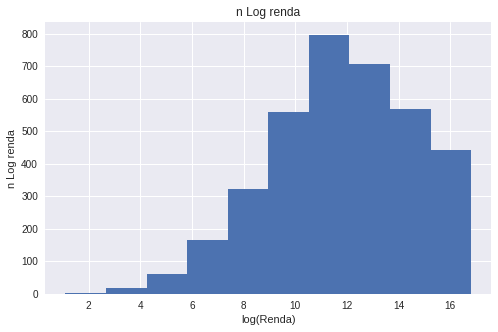

In [193]:
df4.hist('log_renda', figsize=(8,5))
plt.title('n Log renda')
plt.ylabel('n Log renda')
plt.xlabel("log(Renda)")

Text(0.5, 0, 'Renda')

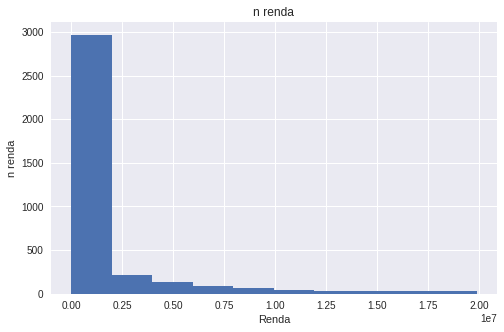

In [194]:
df4.hist('renda',figsize=(8,5))
plt.title('n renda')
plt.ylabel('n renda')
plt.xlabel("Renda")

In [195]:
# Teste Shapiro de normalidade

shapiro(df4['log_renda'])

# O p-value de 2.301 (>0,05) atesta a normalidade da nova variável.

ShapiroResult(statistic=0.9840274453163147, pvalue=7.346929020286201e-20)

Podemos perceber o quanto a distribuição do log de renda é mais simétrica do que a renda bruta.

In [210]:
df4.drop(columns=['renda', 'tempo_exibicao2', 'genero_Documentário',	'genero_Ficção',	'genero_Não Classificada',	'genero_Vídeomusical'], inplace=True)

#### Matriz de correlação com o log de renda

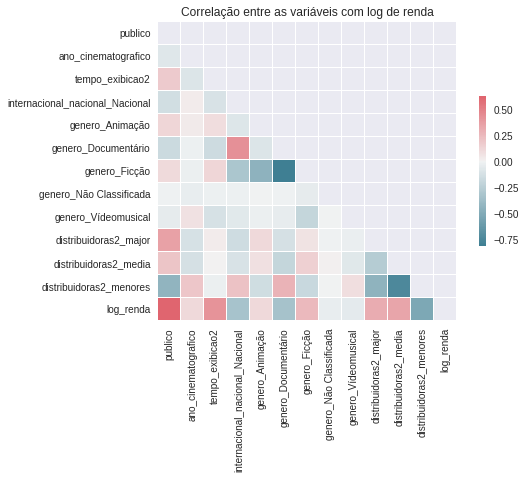

In [197]:
# Um heatmap para log de renda
# Generate a mask for the upper triangle
mask = np.zeros_like(df4.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df4.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Correlação entre as variáveis com log de renda");

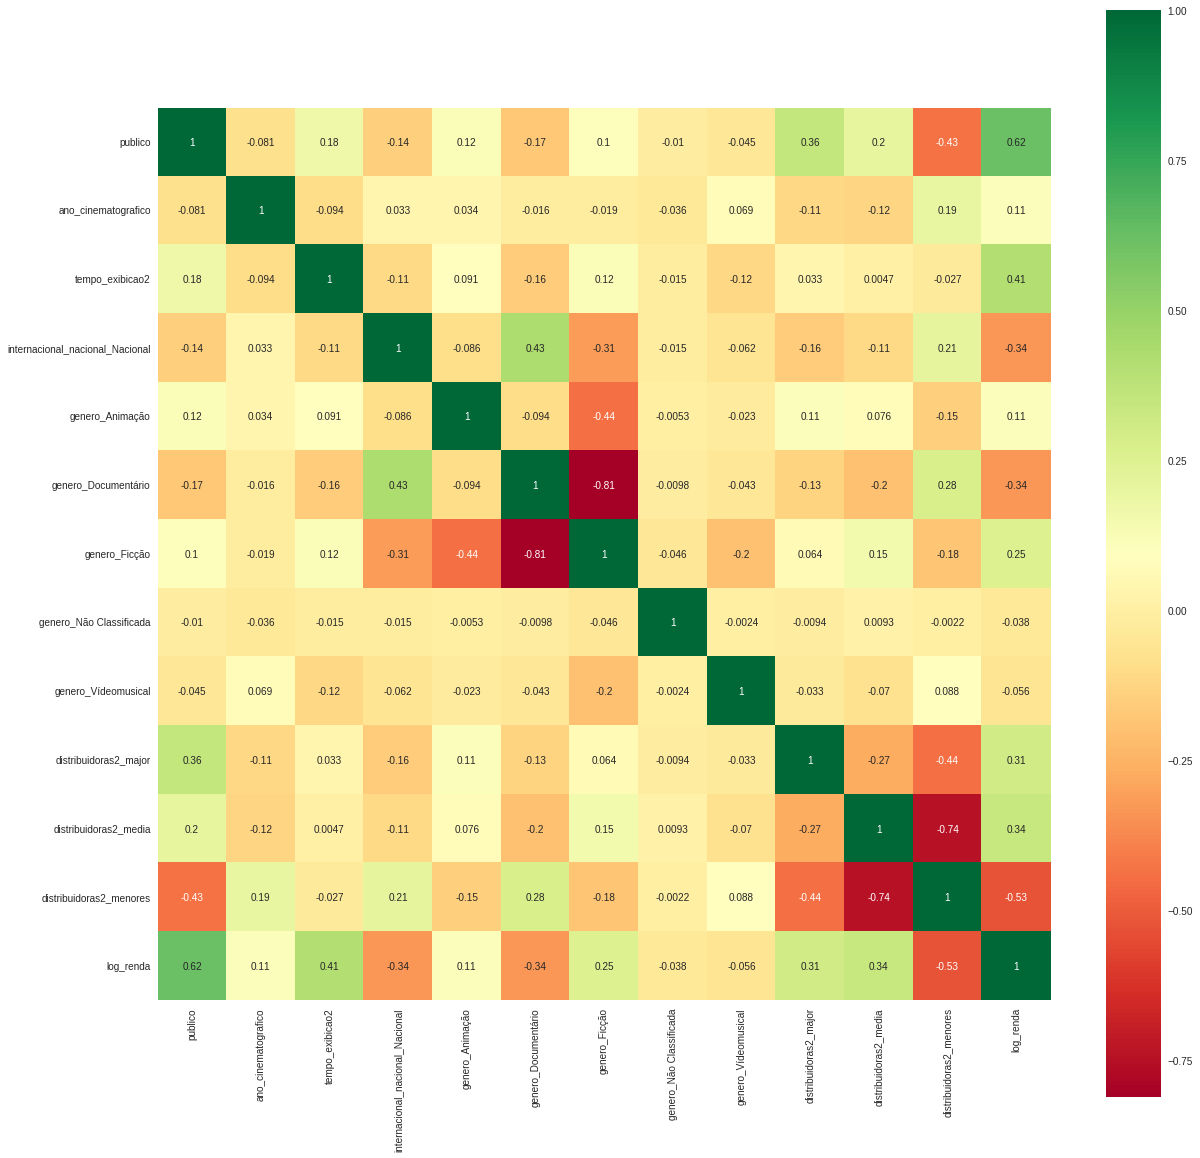

In [198]:
# Novo heatmap
plt.figure(figsize=(20,20))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(df4.corr(), annot=True,cmap='RdYlGn',square=True)  # seaborn has very simple solution for heatmap

Ano parece perder um pouco de importância na correlação com o log de renda na análise bivariada; público, gênero animação, distribuida major e tempo de exibição parecem ter boa correlação com a renda. Vamos checar essas associações no Modelo 3

#### Checando linearidade com o target

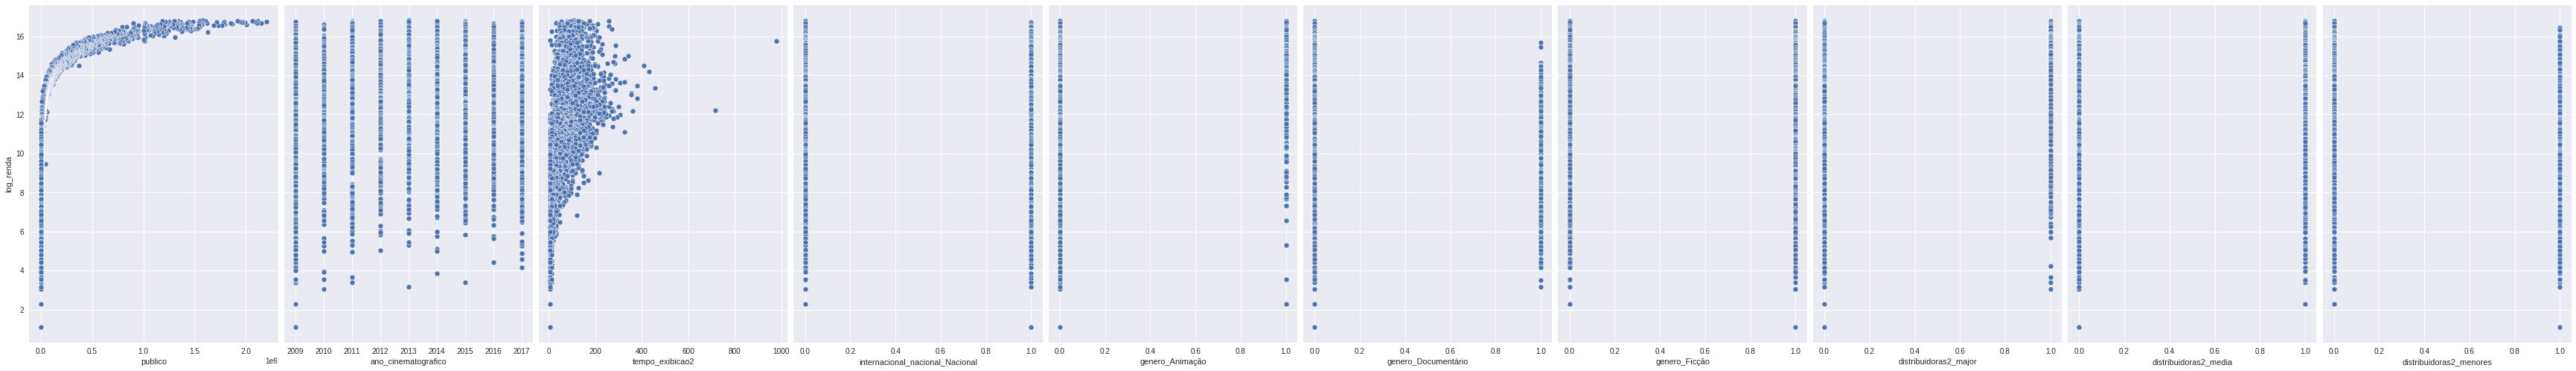

In [199]:
# visualize the relationship between the features and the response using scatterplots
p = sns.pairplot(df4, x_vars=['publico',	'ano_cinematografico',	'tempo_exibicao2',	'internacional_nacional_Nacional',	'genero_Animação',
                              'genero_Documentário',	'genero_Ficção',	'distribuidoras2_major',	'distribuidoras2_media',	'distribuidoras2_menores'], y_vars='log_renda', size=7, aspect=0.7)

#### Separação do conjunto de treino e teste do terceiro modelo

* Com a transformação log da renda



In [200]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import statsmodels.api as sm
from scipy import stats

In [211]:
Y3 = df4['log_renda']
del df4['log_renda']
X3 = df4

In [213]:
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size = 0.25, random_state = 42)

In [214]:
print(X3_train.shape)
X3_train.head(1)

(2729, 7)


,publico,ano_cinematografico,internacional_nacional_Nacional,genero_Animação,distribuidoras2_major,distribuidoras2_media,distribuidoras2_menores
548,511353,2014,0,0,1,0,0


In [215]:
print(Y3_train.shape)
Y3_train.head(1)

(2729,)


548   15.499231299
Name: log_renda, dtype: float64

In [216]:
print(X3_test.shape)
X3_test.head(1)

(910, 7)


,publico,ano_cinematografico,internacional_nacional_Nacional,genero_Animação,distribuidoras2_major,distribuidoras2_media,distribuidoras2_menores
645,391146,2016,0,0,0,1,0


In [206]:
print(Y3_test.shape)
Y3_test.head(1)

(910,)


645   15.443982393
Name: log_renda, dtype: float64

In [217]:
columns3 = ['publico', 'ano_cinematografico', 'internacional_nacional_Nacional', 'genero_Animação', 
            'distribuidoras2_major', 'distribuidoras2_media', 'distribuidoras2_menores']

# Features no modelo: publico, ano, tempo_exibicao2, internacional_nacional, genero, distribuidoras2

#### Definição do Modelo 3

In [218]:
lm3 = LinearRegression()

In [219]:
lm3.fit(X3_train[columns3], Y3_train)

LinearRegression()

In [220]:
Y3_pred = lm3.predict(X3_test[columns3])

In [221]:
beta3 = lm3.coef_
intercept3 = lm3.intercept_

In [222]:
beta3.tolist()

[4.394862466021693e-06,
 0.23835163594237363,
 -1.2542839499983909,
 -0.31646084254428747,
 0.4973916795689638,
 0.6737228857091013,
 -1.1711145652780646]

In [223]:
intercept3

-468.02330890619515

#### Métricas do Modelo 3

In [224]:
mae3 = mean_absolute_error(Y3_test, Y3_pred)
mae3

1.3896724623395624

In [225]:
r2_score(Y3_test, Y3_pred)

0.572632921584254

In [226]:
weights3 = pd.DataFrame(list(zip(columns3, lm3.coef_.tolist())),columns=['names', 'coefs'])
weights3

,names,coefs
0,publico,0.000004395
1,ano_cinematografico,0.238351636
2,internacional_nacional_Nacional,-1.254283950
3,genero_Animação,-0.316460843
4,distribuidoras2_major,0.497391680
5,distribuidoras2_media,0.673722886
6,distribuidoras2_menores,-1.171114565


In [227]:
X3sq = sm.add_constant(X3_test[columns3])
est3 = sm.OLS(Y3_test, X3sq)
est3sq = est3.fit()
print(est3sq.summary())

                            OLS Regression Results                            
Dep. Variable:              log_renda   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     210.2
Date:                Mon, 26 Sep 2022   Prob (F-statistic):          1.42e-167
Time:                        18:57:37   Log-Likelihood:                -1802.0
No. Observations:                 910   AIC:                             3618.
Df Residuals:                     903   BIC:                             3652.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

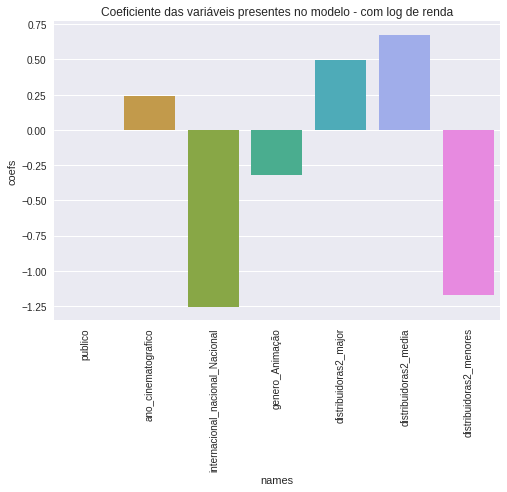

In [229]:
sns.barplot(weights3.names, weights3.coefs).set_title("Coeficiente das variáveis presentes no modelo - com log de renda");
plt.xticks(rotation=90);

# Análise de resíduos do Modelo 3

- Apesar do r2 ter tido um desempenho 

Text(0.5, 1.0, 'Distribuição dos resíduos')

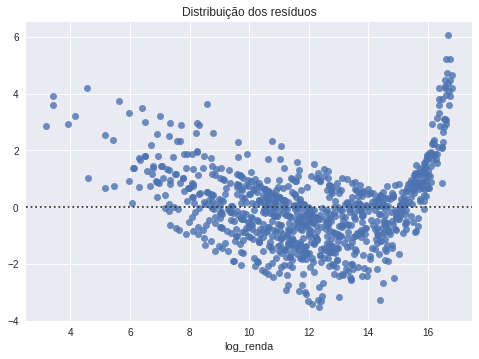

In [230]:
sns.residplot(x=Y3_test, y=Y3_pred).set_title("Distribuição dos resíduos")

#### Comparação dos resíduos dos três modelos

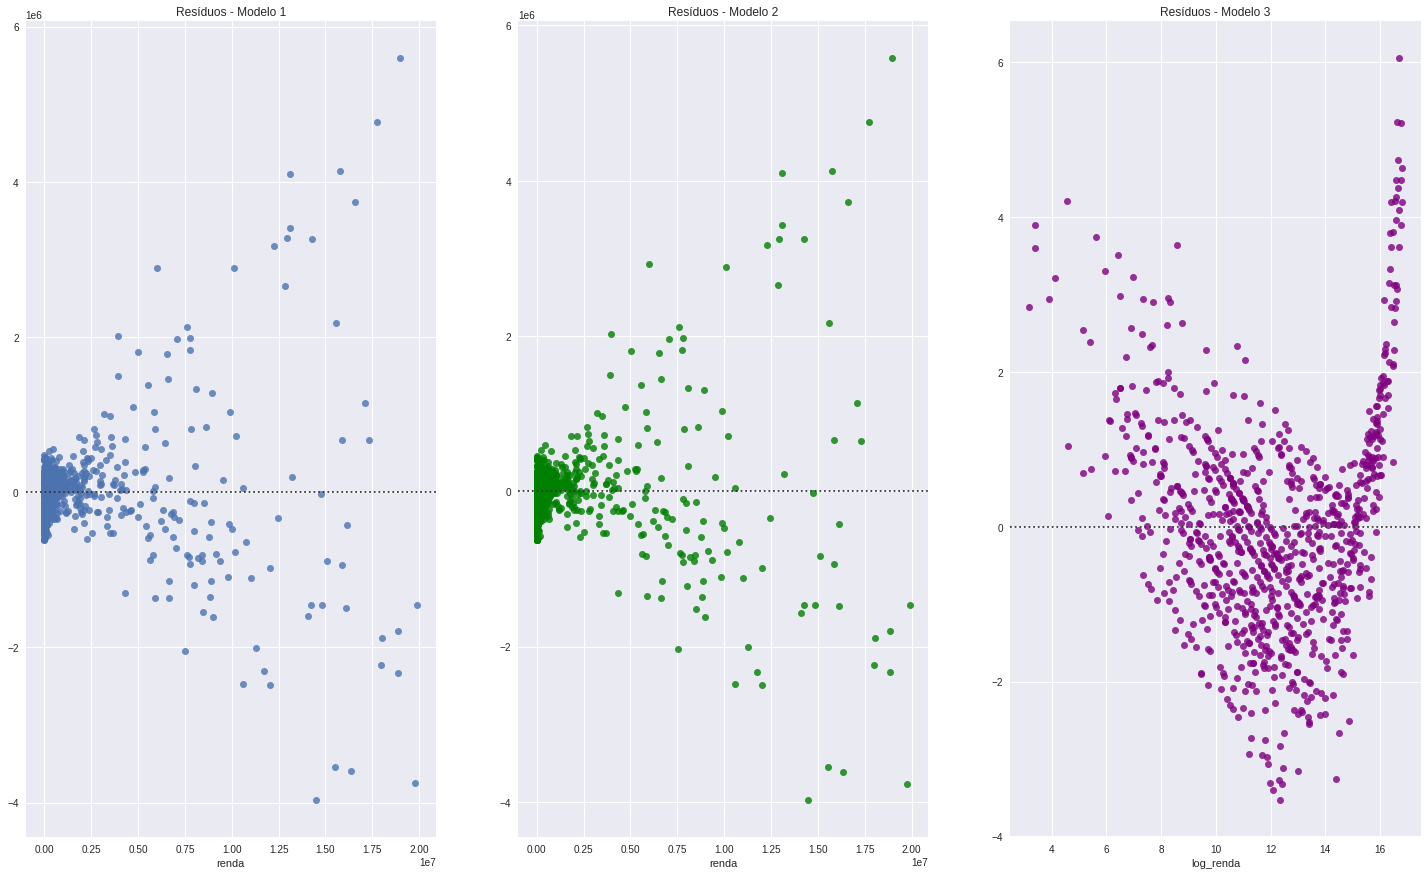

In [231]:
fig,ax =plt.subplots(1,3, figsize=(25, 15)) #sharey=True)
sns.residplot(x=Y_test, y=Y_pred,ax=ax[0]).set_title("Resíduos - Modelo 1")
sns.residplot(x=Y2_test, y=Y2_pred,ax=ax[1], color = 'green').set_title("Resíduos - Modelo 2")
sns.residplot(x=Y3_test, y=Y3_pred, ax=ax[2], color = 'purple').set_title("Resíduos - Modelo 3")
fig.show()

In [232]:
residuals = Y3_test.values-Y3_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals 0.14895784649629715


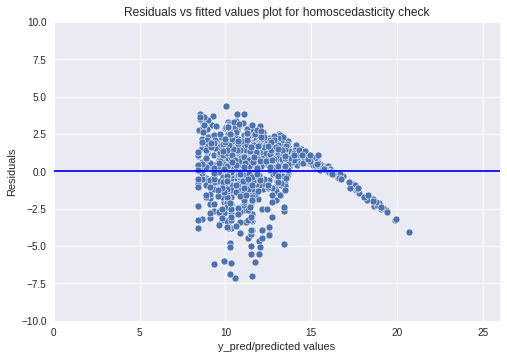

In [233]:
p = sns.scatterplot(Y3_pred,residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='blue')
p = plt.title('Residuals vs fitted values plot for homoscedasticity check')

#### Goldfeld Quandt Test
Checking heteroscedasticity : Using Goldfeld Quandt we test for heteroscedasticity.

Null Hypothesis: Error terms are homoscedastic
Alternative Hypothesis: Error terms are heteroscedastic.

In [234]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X3_test)
lzip(name, test)

[('F statistic', 0.9040864445967062), ('p-value', 0.8568484366882279)]

#### Check for Normality of error terms/residuals

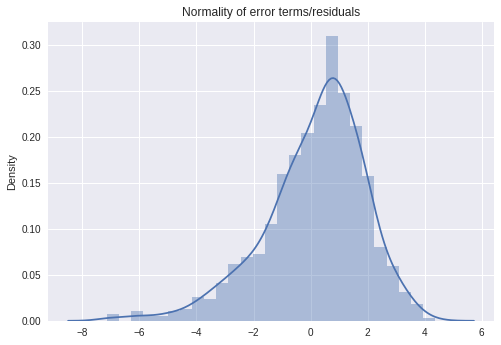

In [235]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

#### No autocorrelation of residuals
When the residuals are autocorrelated, it means that the current value is dependent of the previous (historic) values and that there is a definite unexplained pattern in the Y variable that shows up in the error terms. Though it is more evident in time series data.
In plain terms autocorrelation takes place when there's a pattern in the rows of the data. This is usual in time series data as there is a pattern of time for eg. Week of the day effect which is a very famous pattern seen in stock markets where people tend to buy stocks more towards the beginning of weekends and tend to sell more on Mondays. There's been great study about this phenomenon and it is still a matter of research as to what actual factors cause this trend.
There should not be autocorrelation in the data so the error terms should not form any pattern.

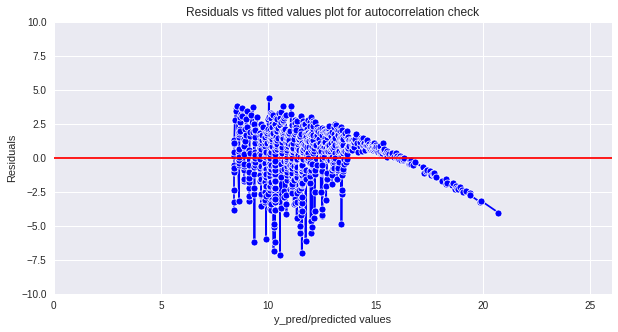

In [236]:
plt.figure(figsize=(10,5))
p = sns.lineplot(Y3_pred,residuals,marker='o',color='blue')
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.ylim(-10,10)
plt.xlim(0,26)
p = sns.lineplot([0,26],[0,0],color='red')
p = plt.title('Residuals vs fitted values plot for autocorrelation check')

#### Checking for autocorrelation To ensure the absence of autocorrelation we use Ljungbox test.
Null Hypothesis: Autocorrelation is absent.
Alternative Hypothesis: Autocorrelation is present.

In [237]:
from statsmodels.stats import diagnostic as diag
min(diag.acorr_ljungbox(residuals , lags = 40)[1])

0.062237901734458444

#### No perfect multicollinearity
In regression, multicollinearity refers to the extent to which independent variables are correlated. Multicollinearity affects the coefficients and p-values, but it does not influence the predictions, precision of the predictions, and the goodness-of-fit statistics. If your primary goal is to make predictions, and you don’t need to understand the role of each independent variable, you don’t need to reduce severe multicollinearity.

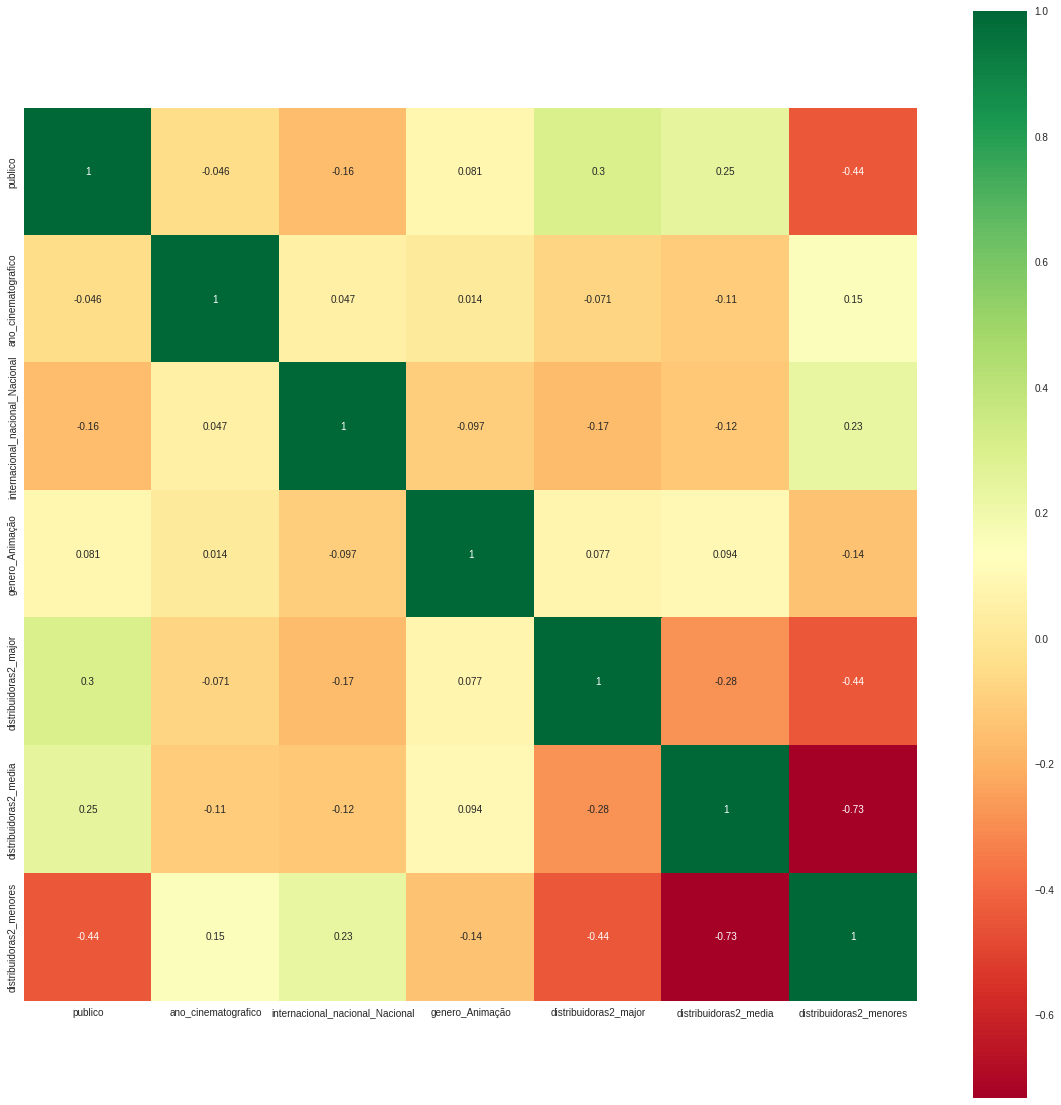

In [238]:
plt.figure(figsize=(20,20))  # on this line I just set the size of figure to 12 by 10.
p=sns.heatmap(X3_test.corr(), annot=True,cmap='RdYlGn',square=True)  # seaborn has very simple solution for heatmap


## Vou refazer mas com o df4 inteiro

Correlation within independent variables is what we need to look for and avoid. This data doesn't contain perfect multicollinearity among independent variables. In case there was any then we would try to remove one of the correlated variables depending on which was more important to our regression model.

Fonte da parte de resíduos [aqui](https://www.kaggle.com/code/shrutimechlearn/step-by-step-assumptions-linear-regression).

#### Diagnósticos (Modelo 3)

- Tenho a impressão que um dos nossos problemas é a correlação entre as features (variáveis independentes), por isso a distribuição de resíduos não é aleatória. O modelo não cumpre o pressuposto de homocedasticidade. Podemos tirar gênero documentário e ver como as demais se comportam; também podemos retirar algma das categorias de distribuidora...
- Os outliers ainda podem ser um problema, talvez seja uma boa mesmo separar o banco em dois e modelar separadamente, com os filmes de altíssimo rendimento de fora.
- Tempo de exibição também não tem uma relação linear com renda, o que pode ser um problema.
- Os gráficos para checar se há ou não linearidade com o target tamabém mostram que para pelo as duas três variáveis numéricas: público, tempo de exibição e ano, não é possível aceitar que cumprimos os pressupostos. Ou seja, é possível que também tenhamos um problema de linearidade.
